In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import feature_extraction
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import string
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from transformers import BertForSequenceClassification, AdamW, BertConfig


import re
import emoji
from spellchecker import SpellChecker

In [78]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

test_ids = test['id']
y_train = train['target']

In [79]:
train = train.drop(['id'], axis=1)
train = train.drop(['target'], axis=1)
test = test.drop(['id'], axis=1)

In [80]:
train.shape

(7613, 3)

In [81]:
test.shape

(3263, 3)

In [82]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
dtypes: object(3)
memory usage: 178.6+ KB


In [83]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   3237 non-null   object
 1   location  2158 non-null   object
 2   text      3263 non-null   object
dtypes: object(3)
memory usage: 76.6+ KB


In [84]:
train = train.fillna('None')
test = test.fillna('None')

In [85]:
stopwords= nltk.corpus.stopwords.words('english')

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)


def remove_stopwords(text):
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in stopwords]
    text = ' '.join([str(elem) for elem in tokens_without_sw])
    return text

def lemma(text):
    tokens = word_tokenize(text)
    wnl = WordNetLemmatizer()
    text = ' '.join([wnl.lemmatize(words) for words in tokens])
    return text



def cleanTweet(txt):
    txt = txt.lower()
    
    txt = re.sub(r'@[A-Za-z0-9_]+','',txt)
    txt = re.sub(r'#','',txt)
    txt = re.sub(r'RT : ','',txt)
    txt = re.sub(r'\n','',txt)
    # to remove emojis
    txt = re.sub(emoji.get_emoji_regexp(), r"", txt)
    txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+','',txt)
    txt = re.sub(r"https?://\S+|www\.\S+","",txt)
    txt = re.sub(r"<.*?>","",txt)
    
    txt = remove_URL(txt)
    txt = remove_HTML(txt)
    txt = remove_not_ASCII(txt)
    
    txt = txt.lower()
    
    txt = remove_number(txt)
    
    txt = remove_stopwords(txt)
    txt = lemma(txt)
    return txt  

In [86]:
train["clean_text"] = train["text"].apply(cleanTweet)
test["clean_text"] = test["text"].apply(cleanTweet)


In [87]:
train.head()

,keyword,location,text,clean_text
0,None,None,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive u
1,None,None,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask . canada
2,None,None,All residents asked to 'shelter in place' are ...,resident asked 'shelter place ' notified offic...
3,None,None,"13,000 people receive #wildfires evacuation or...",NUMBER people receive wildfire evacuation orde...
4,None,None,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfire pour...


In [88]:
train =  train.drop(['text','keyword','location'], axis=1)
train.head()

,clean_text
0,deed reason earthquake may allah forgive u
1,forest fire near la ronge sask . canada
2,resident asked 'shelter place ' notified offic...
3,NUMBER people receive wildfire evacuation orde...
4,got sent photo ruby alaska smoke wildfire pour...


In [89]:
test = test.drop(['text','keyword','location'],axis=1)

In [90]:
train['target'] = y_train

data_disaster = train[train['target'] == 1]
data_non_disaster = train[train['target'] == 0]

In [91]:
wordcloud_1 = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(data_disaster['clean_text']))

wordcloud_0 = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(data_non_disaster['clean_text']))

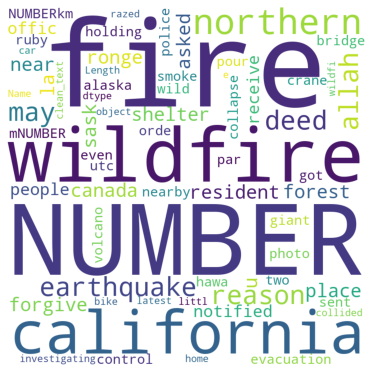

In [92]:
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud_1)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

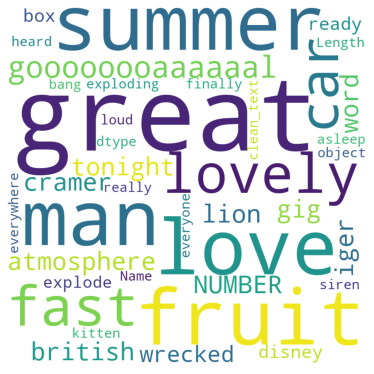

In [93]:
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud_0)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

In [94]:
X_train, X_valid, y_training, y_valid = train_test_split(train, y_train, test_size=0.2, random_state=1)

# Neural Network Models

In [95]:
import tensorflow as tf
import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding

In [96]:
sentences = train['clean_text'].tolist()

labels = y_train.values.tolist()

In [97]:
max = 0
for i in sentences:
    if len(i)>max:
        max = len(i)
        
print(max)

172


In [106]:
vocab = 50000
oov = '<OOV>'
embedding = 32
padding = 'post'
truncate = 'post'
maxlength = 100

In [107]:
ratio = 0.8*len(sentences)
ratio = int(ratio)
# print(ratio)
train = sentences[0:ratio]
train_label = labels[0:ratio]
val = sentences[ratio:]
val_labels = labels[ratio:]

In [108]:
tokenizer =Tokenizer(num_words = vocab, oov_token=oov)
tokenizer.fit_on_texts(train)
word_index = tokenizer.word_index
training = tokenizer.texts_to_sequences(train)
training_pad = pad_sequences(training, maxlen=maxlength, padding=padding, truncating=truncate)

validation = tokenizer.texts_to_sequences(val)
validation_pad = pad_sequences(validation, maxlen=maxlength, padding=padding, truncating=truncate)

In [109]:
test_sentences = test['clean_text'].tolist()
test_sen_token = tokenizer.texts_to_sequences(test_sentences)
test_pad = pad_sequences(test_sen_token, maxlen=maxlength, padding=padding, truncating=truncate)

In [110]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab, embedding, input_length=maxlength),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           1600000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 200)               6600      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 1,606,801
Trainable params: 1,606,801
Non-trainable params: 0
_________________________________________________________________


In [111]:
val_labels = np.array(val_labels)
train_label = np.array(train_label)

In [112]:
model_check = tf.keras.callbacks.ModelCheckpoint('model.h5',save_best_only = True)

In [113]:
num_epochs = 7
history = model.fit(training_pad, 
                    train_label, 
                    epochs=num_epochs, 
                    validation_data=(validation_pad, val_labels),
                    callbacks = [model_check])


Epoch 1/7
191/191 [==============================] - 6s 25ms/step - loss: 0.6824 - accuracy: 0.5662 - val_loss: 0.6872 - val_accuracy: 0.5345
Epoch 2/7
191/191 [==============================] - 5s 24ms/step - loss: 0.6480 - accuracy: 0.6135 - val_loss: 0.5488 - val_accuracy: 0.7951
Epoch 3/7
191/191 [==============================] - 4s 23ms/step - loss: 0.4316 - accuracy: 0.8369 - val_loss: 0.4555 - val_accuracy: 0.8037
Epoch 4/7
191/191 [==============================] - 4s 23ms/step - loss: 0.3123 - accuracy: 0.8754 - val_loss: 0.4486 - val_accuracy: 0.8043
Epoch 5/7
191/191 [==============================] - 5s 24ms/step - loss: 0.2566 - accuracy: 0.8981 - val_loss: 0.4676 - val_accuracy: 0.7794
Epoch 6/7
191/191 [==============================] - 4s 23ms/step - loss: 0.2037 - accuracy: 0.9245 - val_loss: 0.5512 - val_accuracy: 0.7262
Epoch 7/7
191/191 [==============================] - 4s 23ms/step - loss: 0.1984 - accuracy: 0.9262 - val_loss: 0.4937 - val_accuracy: 0.7886


In [ ]:
tf.keras.backend.clear_session()
model_lstm2 = Sequential()
model_lstm2.add(Embedding(vocab, embedding, input_length=maxlength))
model_lstm2.add(LSTM(5))
model_lstm2.add(Dense(25, activation='relu'))
model_lstm2.add(Dense(1, activation='sigmoid'))
model_lstm2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_lstm2 = model_lstm2.fit(training_pad, 
                                train_label, 
                                epochs=15,
                                validation_data=(validation_pad, val_labels),
                                batch_size=32)

In [ ]:
predictions = model.predict(test_pad)

In [ ]:
pred = []
for i in range(0,len(predictions)):
    if predictions[i][0]>0.5:
         pred.append(1)
    else:
        pred.append(0)

In [ ]:
df_results = pd.DataFrame({'id': test_ids, 'target': pred})
df_results.head()

In [ ]:
df_results.to_csv('results9.csv', index=False) 